# Narcos

The very mention of Latin America often evokes violent images of the Narcos Netflix series showcasing Pablo Escobar's bloody drug empire in Colombia. This project takes a look at World Bank data, including terror risk, violent crime and gender violence, to see which countries in Latin America are the most dangerous today.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

path = os.getcwd()

## Import data

### Functions

In [2]:
# takes a wide dataframe (with years for columns) and returns a long one (with many rows).
# uses the most recent year in which there was no NA value. 
def make_df_long(df, col_name, switch):
    # creates a years list with the most recent first
    data_years = df.iloc[:, 1:].iloc[:, ::-1].columns

    # iterates through each row and year untill a 
    # non-na value is found. 
    year = []
    value = []
    for row_x in range(len(df)):
        for year_x in data_years:
            datum = df.loc[row_x, year_x]
            if not np.isnan(datum):
                year.append(year_x)
                value.append(datum)
                break
            # if no non-na value is found, NAs are appended
            else:
                if year_x == data_years[len(data_years)-1]:
                    year.append(np.nan)
                    value.append(np.nan)

    # creates a long dataframe with country, year and values as columns. 
    df = pd.DataFrame({'country': df['country'], 
                       'year': year,
                       col_name: value})

    # changes positive to negative values if switch is set to true
    if switch == True:
        df[col_name] = df[col_name].apply(lambda x: -x)

    return df


# imports world bank data in wide format
def import_WB_wide_data(df, col_name, switch=False):
    # read-in world bank data
    data = pd.read_csv(path + '\\' + df + '.csv')

    # define the number of columns
    col_len = len(data.columns)
    
    # define last 7 years
    last_7_years = range((col_len-7), col_len)
    
    # trim the data to country names and the last 7 years
    df = pd.concat([data.loc[:, 'Country Name'], data.iloc[:,last_7_years]], axis=1)
    
    # renames the country column for simplicity
    df.rename(columns={'Country Name': 'country',
                       'value': col_name}, inplace=True) 

    # returns a long dataframe with the most 
    return make_df_long(df, col_name, switch)


# imports world bank data in long format
def import_WB_long_data(df, col_name):
    # read-in world bank data
    data = pd.read_csv(path + '\\' + df + '.csv')

    # trim the data to country names and modeled 2018 data
    df = data.loc[data['Disaggregation']=='female, 15-49, Modeled', ['Country Name', 'Year', 'Value']]

    # returns a dataframe with a renamed country column for simplicity
    return df.rename(columns={'Country Name': 'country',
                              'Year': 'year',
                              'Value': col_name}) 

### Terror Risk Data

In [3]:
# reads in the data
PS_df = import_WB_wide_data(df='political_stability', col_name='terror_risk', switch=True)

# prints the first 6 rows
PS_df.head(6)

,country,year,terror_risk
0,Aruba,2022,-97.641510
1,Africa Eastern and Southern,NaN,NaN
2,Afghanistan,2022,-0.471698
3,Africa Western and Central,NaN,NaN
4,Angola,2022,-22.641510
5,Albania,2022,-50.471699


### Intentional Homicides Data

In [4]:
# reads in the data
IH_df = import_WB_wide_data(df='intentional_homocides', col_name='violent_crime')

# prints the first 6 rows
IH_df.head(6)

,country,year,violent_crime
0,Aruba,NaN,NaN
1,Africa Eastern and Southern,NaN,NaN
2,Afghanistan,2021,4.022498
3,Africa Western and Central,NaN,NaN
4,Angola,2016,4.102248
5,Albania,2021,2.311969


### Sexual Violence Data

In [5]:
# reads in the data
SV_df = import_WB_long_data(df='sexual_violence_last_12_months', col_name='sexual_violence')

# shows the data
SV_df.head(6)

,country,year,sexual_violence
0,East Asia & Pacific,2018,7.928985
1,Europe & Central Asia,2018,6.317913
2,High income,2018,5.601072
3,Latin America & Caribbean,2018,8.306678
4,Low income,2018,22.482199
5,Lower middle income,2018,16.864853


## Process Data

### Standardize country names

In [6]:
# returns the country name of a given dataframe based on a string match
def get_country_name(df_name, data, string, col_name='country'):
    result = data.loc[[string in x for x in data[col_name]], col_name].values
    # prints a warning of the string matches more than one country name
    if len(result)>1:
        print('WARNING! Potentially 2 countries with same name!!!!' + ' --- ' + result)
        
    # in most cases returns the country name result
    elif len(result)<1:
        raise ValueError(string + ' not in ' + df_name)

    # returns the name in the dataframe
    return result[0]

# changes a country name in a given dataframe to make it uniform
def change_country_name(data, name, country, col_name='country'):
    data.loc[data[col_name]==name, col_name] = country

# standardizes country names for a given dataframe
def standardize_df_country_names(df, col_name='country'):
    for country in countries:
        name = get_country_name(df, eval(df), country)
        if name != country:
            change_country_name(eval(df), name, country)

# a list of relevant countries
countries = ['Colombia', 'Brazil', 'Peru', 'Argentina', 'Venezuela', 'Chile', 'Ecuador', 'Bolivia', 'Uruguay', 'Paraguay',
             'Panama', 'Guatemala', 'El Salvador', 'Belize', 'Nicaragua', 'Honduras', 'Costa Rica', 'Mexico',
             'Dominican Republic', 'Cuba', 'Haiti']

# sorts the countries by country name
countries.sort()

# a list of dataframes
dfs = ['PS_df', 'IH_df', 'SV_df']

# loops through each dataframe and stores relevant values in the dataframes object
for df in dfs:
    country = standardize_df_country_names(df)

### Create a combined dataframe

In [7]:
# creates a pandas dataframe with a countries column
combined_df = pd.DataFrame({'country': countries})

# adds in the other columns for each datatype
for df in dfs:
    df = eval(df)
    data = df[df['country'].isin(countries)].sort_values('country').iloc[:,2].reset_index(drop=True)
    name = data.name
    combined_df[name] = data

# shows the data
combined_df.head(6)

,country,terror_risk,violent_crime,sexual_violence
0,Argentina,-46.698112,4.622679,5.0
1,Belize,-59.433964,31.247578,8.0
2,Bolivia,-36.320755,3.493530,18.0
3,Brazil,-33.962265,22.384065,6.0
4,Chile,-51.415092,3.632039,6.0
5,Colombia,-23.113207,27.484365,12.0


### View NAs

In [8]:
# determuine how many NAs are in each data source
new_df = combined_df.iloc[:,1:len(combined_df.columns)]
cols = new_df.columns

print()
for i, col in enumerate(cols):
    print(str(col) + ' --- NAs --- ' + str(new_df.iloc[:,i].isnull().sum()))


terror_risk --- NAs --- 0
violent_crime --- NAs --- 0
sexual_violence --- NAs --- 0


### Trim outliers 

In [9]:
# trims outliers to a certain standard deviation
def trim_outliers(data):
    
    mean = np.mean(data)
    std = np.std(data)
    
    # define the cutoffs in standard deviations
    lower_limit = mean - (1.5 * std)
    upper_limit = mean + (1.5 * std)
    
    # use np.clip to limit the values to the defined range
    trimmed_data = np.clip(data, lower_limit, upper_limit)
    
    return trimmed_data

# iterates over the columns
for col in cols:
    combined_df[col] = trim_outliers( combined_df[col] )

### Normalize values

In [10]:
# normalizes values by scalling to range, multiplying the result by 5 and then rounding that to the nearest 2 digits.
# this gives us a relative 0-5 score for each column. 
def normalize_values(df, column):
    max = df[column].max()
    min = df[column].min()
    # adds 5 to each value to represent that all countries have danger
    return [round(((x - min) / (max - min)) * 5, 2) + 5 for x in df[column]]

# creates a combined df with normalized values
columns = combined_df.columns
for column in columns[1:]:
    combined_df[column] = normalize_values(combined_df, column)

# shows the dataframe
combined_df.head(6)

,country,terror_risk,violent_crime,sexual_violence
0,Argentina,7.13,5.22,5.57
1,Belize,6.07,10.00,7.28
2,Bolivia,7.99,5.00,10.00
3,Brazil,8.19,8.62,6.14
4,Chile,6.74,5.03,6.14
5,Colombia,9.10,9.60,9.55


### Create a Total Column

In [11]:
# defines the weights for terror_risk, violent_crime and sexual_violence
weights = [1, 1.5, 1]

# adds the columns together and divides the result by the number of columns
totals = []
for i in range(len(combined_df)):
    total = 0
    for j, col in enumerate(columns[1:]):
        total = total + (combined_df.loc[i, col]*weights[j])
    totals.append(round(total/len(columns[1:]), 2))

# creates a new total score
combined_df['total_danger'] = totals

# creates a new columns list that includes the total
cols = combined_df.columns[1:]

## Visualize data

### Define parameters

In [12]:
# defines the countries we want to look at
SA_countries = ['Colombia', 'Brazil', 'Peru', 'Argentina', 'Venezuela', 'Chile', 'Ecuador', 'Bolivia', 'Uruguay', 'Paraguay']
CA_countries = ['Panama', 'Guatemala', 'El Salvador', 'Belize', 'Nicaragua', 'Honduras', 'Costa Rica', 'Mexico']
C_countries = ['Dominican Republic', 'Cuba', 'Jamaica', 'Haiti', 'Trinidad and Tobago']

# creates a countries list
countries = ['SA_countries', 'CA_countries', 'C_countries']

# creates a sub-titles list for each region
sub_titles = ['South America', 'Central America', 'The Caribbean']

# inserts a region column
combined_df.insert(1, 'region', 'blank')
for i, region in enumerate(sub_titles):
    combined_df.loc[combined_df['country'].isin(eval(countries[i])), 'region'] = region

# creates a list of column names
cols = combined_df.iloc[:,2:].columns

# creates a y labels list for each plot type
ylabs = ['Political Stability (0-10)', 'Intentional Homicides (0-10)', 'Sexual Violence Against Women (0-10)', 'Total Violence (0-10)']

### Create Subplots

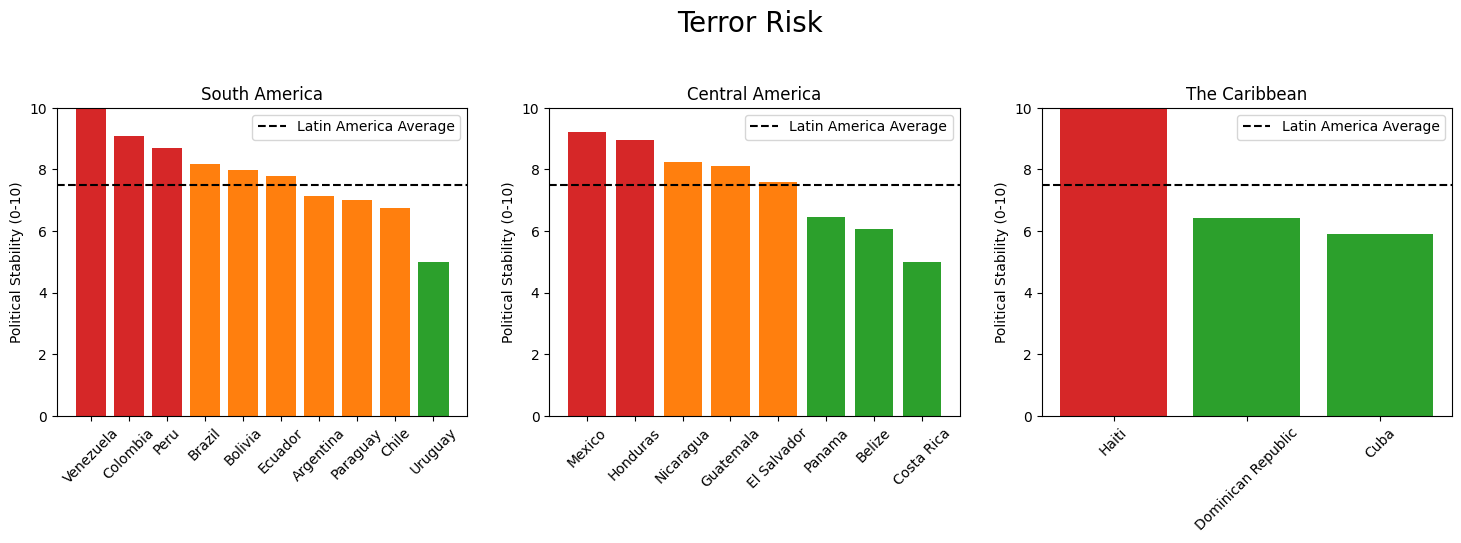

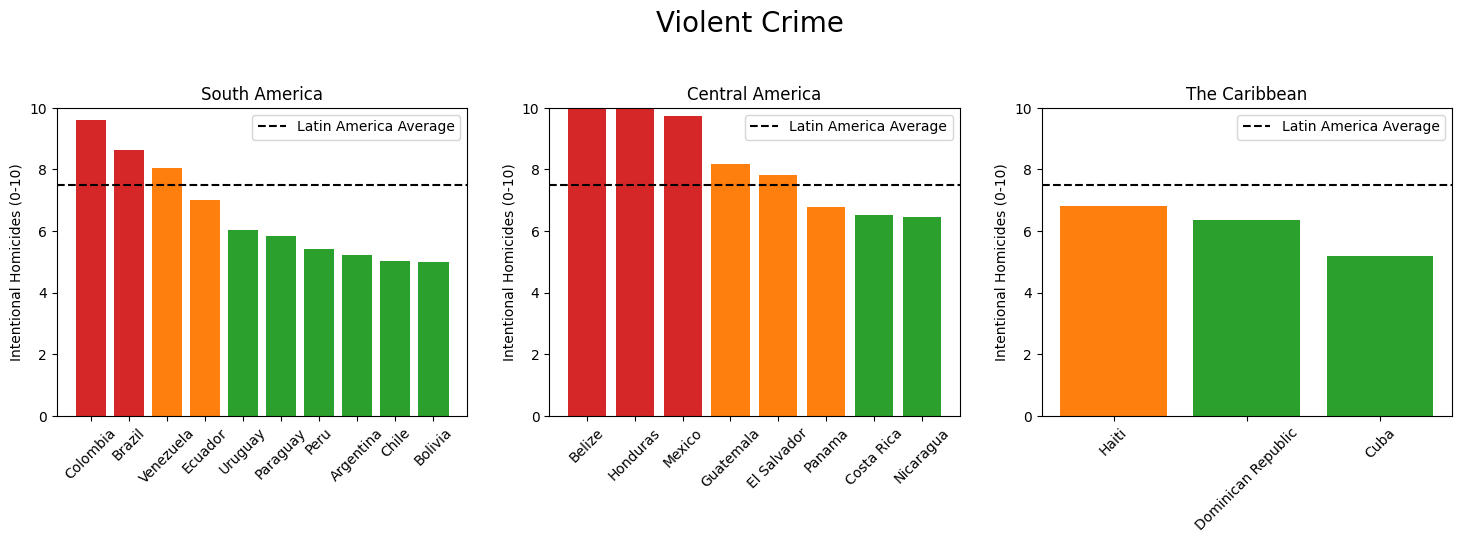

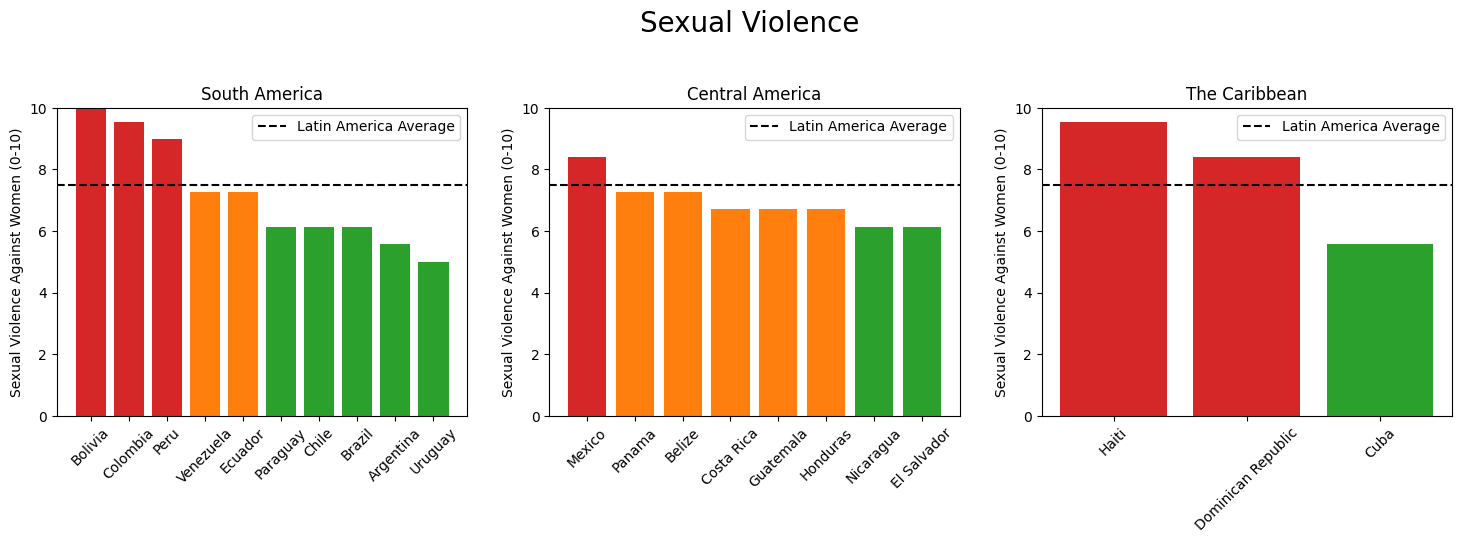

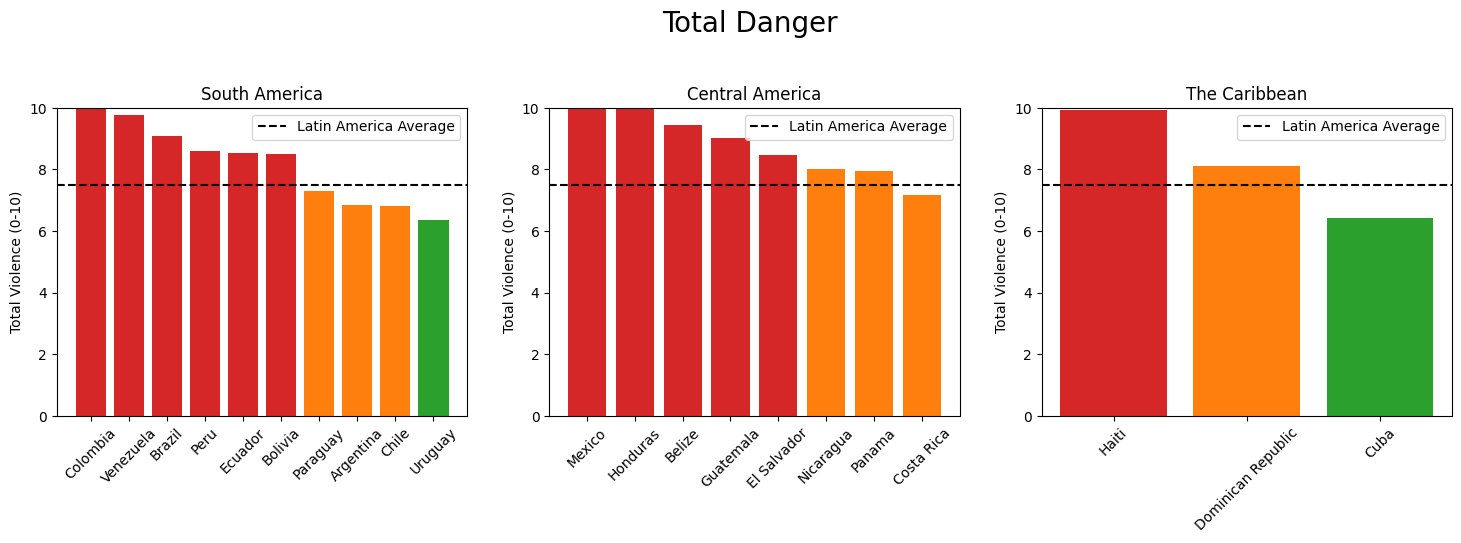

In [13]:
# returns a list of either red, orange or green depending
# on the y values given. 
def get_colors(y):
    colors = []
    for value in y:
        if value <= 6.6:
            colors.append('tab:green')
        elif value <= 8.3:
            colors.append('tab:orange')
        else:
            colors.append('tab:red')
    return colors

# returns  barplots of the data for a selected range of countries
def get_viz(col, ylab):
    
    # creates a subplots objects and flattenes it for easy plotting
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    
    # loops through each plot
    for i, sub_title in enumerate(sub_titles):

        country_booleans = combined_df['country'].isin(eval(countries[i]))
        x = combined_df.sort_values(col, ascending=False).loc[country_booleans, 'country'].reset_index(drop=True)
        y = combined_df.sort_values(col, ascending=False).loc[country_booleans, col].reset_index(drop=True)

        colors = get_colors(y)

        ax[i].bar(x, y, color=colors);
        ax[i].set_title(sub_title);
        ax[i].set_ylabel(ylab);
        ax[i].set_ylim(0,10);
        ax[i].set_xticks(x);
        ax[i].set_xticklabels(x, rotation=45);
        ax[i].axhline(y=7.5, color='black', linestyle='--', label='Latin America Average')
        ax[i].legend()
    
    # adjust layout for better spacing
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    
    # add overall title
    fig.suptitle(' '.join(col.split('_')).title(), fontsize=20, x=0.51, y=1.125)
    
    # show the plots
    plt.show()

# creates the visualizations
for i, col in enumerate(cols):
    get_viz(col=col, ylab=ylabs[i])

### Save Data

In [14]:
combined_df.to_csv('combined_df.csv', index=False)